# **Lab: Invoke FM (**Amazon Nova Canvas**) for Image Generation using API**

---

In this hands-on, we'll explore the powerful capabilities of Amazon Nova Canvas to create compelling visual ads for Octank, a premium dog food company.

---



### **Introduction**
In this notebook, you'll explore Amazon Nova Canvas, a state-of-the-art image generation model that creates high-quality, photorealistic visuals from text prompts. Nova Canvas supports advanced features such as text-to-image generation, inpainting, outpainting, image variation, and subject consistency. These capabilities make it a powerful tool for applications like product visualization, creative design, and content generation—enabling businesses to produce studio-quality images at scale, accelerate content workflows, and enhance customer experiences with highly tailored visuals.

### **Scenario: Marketing Campaign for Octank Premium Dog Food**

Octank is launching a new line of premium dog food and wants to create a series of visually compelling marketing materials to promote the product. To meet this need, they require high-quality images that align with their branding, product aesthetics, and target audience. Using Amazon Nova Canvas, Octank aims to generate a variety of images for their campaign, including product packaging, promotional materials, and social media visuals.

### **Description:**

In this hands-on scenario, Octank will use Amazon Nova Canvas, a powerful image generation model, to create visually striking and highly tailored visuals from text prompts. This model can generate photorealistic images from simple descriptions, adjust styles, and modify existing images with advanced features like inpainting, outpainting, and image variation.

### **Lab Objectives**
By the end of this notebook lab, you will:
- Understand the key features of Amazon Nova Canvas
- Learn how to use these features for a real-world marketing scenario
- Gain hands-on experience with the Amazon Bedrock API for image generation tasks



## 1. Setup

### 1.1 Import Libraries and Init Clients

In [ ]:
# Built-in libraries
import base64
import io
import json
import os
import sys

# External dependencies
import boto3
import botocore
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

# Set up Bedrock client
boto3_bedrock = boto3.client('bedrock-runtime')

### **Explanation of the Code:**

- This code imports **necessary libraries** for working with **image processing** and **AWS services**. It sets up the **client for AWS Bedrock**, which is used to interact with Amazon’s AI models for generating or processing images.


1. **Built-in Libraries**:
   - **`import base64`**:
     - Used to **encode** and **decode** binary data (like images) into/from Base64 format. This is needed when working with data in APIs or when converting images for storage or transfer.
   - **`import io`**:
     - Provides the **streaming interface** for handling I/O operations. In this case, it's used to handle image data in memory (without saving to disk).
   - **`import json`**:
     - Allows working with **JSON data**. It's used to parse and generate JSON, often needed when sending or receiving data from APIs.
   - **`import os`**:
     - Provides a way to interact with the **operating system** (like file and directory manipulation). It can be used to check and create directories, work with file paths, and more.
   - **`import sys`**:
     - Provides system-specific parameters and functions. Here, it's often used for getting system version details or handling script execution details.

2. **External Dependencies**:
   - **`import boto3`**:
     - AWS SDK for Python, used to interact with AWS services. In this case, it’s used to access AWS **Bedrock** services for AI/ML tasks.
   - **`import botocore`**:
     - A low-level interface to AWS services used by **boto3** to handle retries, error management, and service requests.
   - **`import numpy as np`**:
     - **NumPy** is a powerful library for numerical computing. Here, it's used for handling **arrays** and **matrices**, which is especially useful when dealing with image data and processing.
   - **`import matplotlib.pyplot as plt`**:
     - **Matplotlib** is used to create static, animated, and interactive visualizations in Python. It's used here for displaying images and graphs.
   - **`from PIL import Image`**:
     - **Pillow (PIL)** is a library for opening, manipulating, and saving images in various formats. Here, it’s used to handle image files and display them.

3. **Set up Bedrock Client**:
   - **`boto3_bedrock = boto3.client('bedrock-runtime')`**:
     - Creates a **client** to interact with AWS **Bedrock Runtime**. This allows you to use the various **AI/ML models** available through Amazon Bedrock, including generating images or performing other AI tasks.




## 1.2 Implement Helper Functions

The following ultilty function visualizes generated images alongside optional reference images. It's essential for displaying and comparing the results of image generation tasks, allowing you to easily see the input, output, and any relevant color information in a single, organized plot.

In [ ]:
# Utility function: Define plot function
def plot_images(base_images, prompt=None, seed=None, ref_image_path=None, color_codes=None, original_title=None, processed_title=None):

    # Determine the number of subplots needed based on the inputs:
    # If both a reference image and color codes are provided, create 3 subplots
    if ref_image_path and color_codes:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create 3 subplots in one row
        num_subplots = 3
    # If only a reference image or color codes are provided, create 2 subplots
    elif ref_image_path or color_codes:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create 2 subplots in one row
        num_subplots = 2
    # If neither is provided, create just 1 subplot
    else:
        fig, axes = plt.subplots(1, 1, figsize=(6, 5))  # Create 1 subplot
        num_subplots = 1

    # Flatten the axes array (in case of multiple subplots)
    axes = np.array(axes).ravel()

    current_subplot = 0  # Track the current subplot being processed

    # If color codes are provided, display them as color swatches
    if color_codes:
        num_colors = len(color_codes)  # Number of colors to display
        color_width = 0.8 / num_colors  # Determine the width of each color swatch

        # Loop through each color and add it to the first subplot
        for i, color_code in enumerate(color_codes):
            x = i * color_width  # Set the position of the color swatch
            rect = plt.Rectangle((x, 0), color_width, 1, facecolor=f'{color_code}', edgecolor='white')  # Create a rectangle for the color
            axes[current_subplot].add_patch(rect)  # Add the rectangle to the subplot

        # Adjust the axes for color swatches
        axes[current_subplot].set_xlim(0, 0.8)
        axes[current_subplot].set_ylim(0, 1)
        axes[current_subplot].set_title('Color Codes')  # Title for this subplot
        axes[current_subplot].axis('off')  # Turn off the axes
        current_subplot += 1  # Move to the next subplot

    # If a reference image path is provided, display the reference image
    if ref_image_path:
        reference_image = Image.open(ref_image_path)  # Open the reference image
        max_size = (512, 512)  # Resize the image to fit the subplot
        reference_image.thumbnail(max_size)

        # Show the reference image on the subplot
        axes[current_subplot].imshow(np.array(reference_image))

        # Set the title for this subplot (either custom or default to 'Reference Image')
        axes[current_subplot].set_title(original_title or 'Reference Image')
        axes[current_subplot].axis('off')  # Turn off the axes for this image
        current_subplot += 1  # Move to the next subplot

    # Display the generated image from the base_images list (first image in the list)
    axes[current_subplot].imshow(np.array(base_images[0]))

    # Set the title for the generated image based on available details
    if processed_title:
        axes[current_subplot].set_title(processed_title)  # Custom title
    elif ref_image_path and seed is not None:
        axes[current_subplot].set_title(f'Image Generated Based on Reference\nSeed: {seed}')  # Title with seed info
    elif seed is not None:
        axes[current_subplot].set_title(f'Image Generated\nSeed: {seed}')  # Title with seed info
    else:
        axes[current_subplot].set_title('Processed Image')  # Default title for processed image
    axes[current_subplot].axis('off')  # Turn off the axes for this image

    # If a prompt is provided, print it for reference
    if prompt:
        print(f"Prompt: {prompt}\n")

    # Adjust layout to prevent overlapping subplots
    plt.tight_layout()

    # Display the final plot with all the subplots
    plt.show()


### **Explanation of the Code:**

- This function organizes and displays multiple images (such as the generated image, reference image, and color codes) in a structured layout. It allows for flexible visualization of images with their corresponding details (like prompt, seed, etc.).


1. **Function Definition**:
   - **`def plot_images(...):`**:
     - Defines a function named **`plot_images`** that visualizes generated images alongside optional reference images, color codes, and titles.

2. **Subplot Layout**:
   - **`if ref_image_path and color_codes:`**:
     - If both **`ref_image_path`** (reference image) and **`color_codes`** (a list of color codes) are provided, the layout creates **3 subplots**.
   - **`elif ref_image_path or color_codes:`**:
     - If either the reference image or color codes are provided, it creates **2 subplots**.
   - **`else:`**:
     - If neither is provided, it defaults to creating a single subplot.

3. **Create Subplots**:
   - **`fig, axes = plt.subplots(...)`**:
     - Initializes the **subplots** with a specified layout (1 row, 1-3 columns depending on the conditions).
     - **`figsize=(15, 5)`** adjusts the **size** of the plot for better visualization.

4. **Plot Color Codes**:
   - **`if color_codes:`**:
     - If **color codes** are provided, it creates **rectangular color swatches** in the first subplot.
     - Each color code is represented as a **rectangular patch** in the plot.
     - **`axes[current_subplot].set_title('Color Codes')`** sets the title for the color codes subplot.

5. **Plot Reference Image**:
   - **`if ref_image_path:`**:
     - If **`ref_image_path`** is provided, the reference image is loaded and displayed in the next subplot.
     - The image is resized to fit the subplot with **`max_size = (512, 512)`**.
     - **`axes[current_subplot].set_title(original_title or 'Reference Image')`** sets the title of the reference image subplot.

6. **Plot the Generated Image**:
   - **`axes[current_subplot].imshow(np.array(base_images[0]))`**:
     - Displays the **first generated image** (from the **`base_images`** list) in the final subplot.
   - **Title Configuration**:
     - If a **processed title** is provided, it is used as the title.
     - If **`ref_image_path`** and **`seed`** are provided, the title includes the **seed** and indicates that the image was generated based on the reference.
     - If only **`seed`** is provided, the title includes the **seed** value.

7. **Prompt Display**:
   - **`if prompt:`**:
     - If a **prompt** is provided, it is printed to show the text description that was used to generate the image.

8. **Layout and Display**:
   - **`plt.tight_layout()`**:
     - Adjusts the spacing between subplots to ensure they don't overlap.
   - **`plt.show()`**:
     - Displays the final plot with the images.




In [ ]:
# Function to save a base64 encoded image as an actual image file
def save_image(base64_image, output_file):

    # Open the output file in write-binary ('wb') mode to save the image
    with open(output_file, 'wb') as file:

        # Decode the base64 image and write the binary data to the output file
        file.write(base64.b64decode(base64_image))  # Decode and save the image

### **Explanation of the Code:**

- This function **decodes a Base64-encoded image** and saves it as an image file to the specified **output path**. The function ensures that the image is saved in binary format.


1. **Function Definition**:
   - **`def save_image(base64_image, output_file):`**:
     - Defines a function named **`save_image`** that takes two arguments:
       - **`base64_image`**: The **Base64 encoded image** that will be decoded and saved.
       - **`output_file`**: The **path** where the decoded image will be saved.

2. **Open the File for Writing**:
   - **`with open(output_file, 'wb') as file:`**:
     - Opens the **`output_file`** in **write-binary mode** (`'wb'`). This mode is necessary because we are writing binary data (the decoded image) to the file.

3. **Decode and Write Image**:
   - **`file.write(base64.b64decode(base64_image))`**:
     - **`base64.b64decode(base64_image)`**:
       - Decodes the **Base64** encoded image into binary data.
     - **`file.write(...)`**:
       - Writes the decoded binary data to the **`output_file`**.



## 2. Use Cases Implementation

### 2.1 Example: Text to Image


#### Scenario
Octank wants to generate an initial product package design based on a text description.

#### Parameters
1. **prompt**: Describes the desired image
2. **negative_prompts**: Specifies elements to avoid in the image
3. **seed**: For reproducibility


In [ ]:
# Define the prompt
prompt = "A white packet of premium dog food with an American Eskimo dog on it, professional product photography. Dog food is named Octank."
negative_prompts = "poorly rendered, poor background details, poor packet details, poor text details, bleary text"
seed = 42

# Specify path to store the output
output_save_path = "images/after_text-to-image.png"

### **Explanation of the Code:**

- **`prompt`**: The description given to the model to generate the image.
- **`negative_prompts`**: These are qualities you don’t want in the generated image.
- **`seed`**: Ensures that the same image can be generated again with the same conditions.
- **`output_save_path`**: Specifies the location on your system where the generated image will be saved.

This code is used to set up the parameters for generating an image using text prompts, where you control both the positive and negative aspects of the image, along with specifying where to save the output.


In [ ]:
# Importing necessary libraries
import os  # This library helps with interacting with the operating system, like creating folders
import base64  # This library is used to decode data that is encoded in base64 format

# Create the folder before saving any images ---
os.makedirs("images", exist_ok=True)  # This line ensures that a folder named "images" exists. If it doesn't, it creates it.

# --- Helper function to save images ---
def save_image(base64_image, output_file):
    # Ensure folder exists (extra safety)
    folder = os.path.dirname(output_file)  # Extracts the folder path from the output file path (e.g., "images/output.jpg")

    # If the folder doesn't exist, create it
    if folder and not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)  # Creates the folder if it doesn't already exist

    # Open the output file in write-binary ('wb') mode and save the image
    with open(output_file, 'wb') as file:  # Open the specified file for writing in binary mode
        file.write(base64.b64decode(base64_image))  # Decode the base64 image and save it as binary data to the file

# Confirmation message
print("✔️ Image folder created and save_image() is ready to use.")  # Prints a message confirming that the folder and function are ready


✔️ Image folder created and save_image() is ready to use.


### **Explanation of the Code:**

- This code ensures that an **`images`** folder is created (if it doesn't already exist) and then uses the **`save_image()`** function to decode a **Base64** string into an image and save it as a file on your local system.


1. **`import os`**:
   - Imports the **`os`** module to interact with the operating system, such as working with directories.

2. **`import base64`**:
   - Imports the **`base64`** module to encode and decode binary data, such as images, in **Base64** format.

3. **`os.makedirs("images", exist_ok=True)`**:
   - Creates the **`images`** folder if it doesn't exist yet.
   - The `exist_ok=True` parameter prevents an error if the folder already exists.

4. **`save_image(base64_image, output_file)`**:
   - This function is designed to **decode a Base64 image** and **save it as a file**.
   
   - **Steps**:
     - **Ensuring the Folder Exists**: Before saving the image, the function checks if the folder (in the `output_file` path) exists. If not, it creates it using **`os.makedirs()`**.
     - **Saving the Image**: The function opens the specified **`output_file`** in **binary write mode** (`'wb'`) and writes the decoded image data (using `base64.b64decode()`).

5. **`print("✔️ Image folder created and save_image() is ready to use.")`**:
   - Prints a message confirming that the folder has been created and the **`save_image()`** function is ready to use.





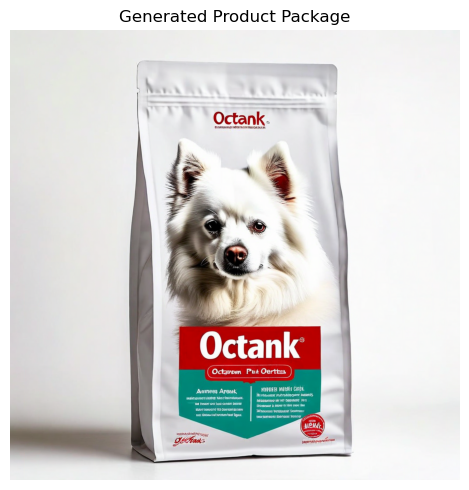

In [ ]:
# Generate text-to-image
body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",  # Specify the task type: "TEXT_IMAGE" for generating an image from text
        "textToImageParams": {
            "text": prompt,  # The required text description to generate the image (e.g., product description)
            "negativeText": negative_prompts  # Optional: Specifies aspects you don't want in the generated image (e.g., low quality)
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,  # How many images to generate (between 1 and 5)
            "quality": "standard",  # Image quality (options: "standard" or "premium")
            "height": 1024,  # Height of the generated image (in pixels)
            "width": 1024,  # Width of the generated image (in pixels)
            "cfgScale": 7.5,  # Controls the image generation process (value between 1.0 to 10.0)
            "seed": 250  # Seed for randomness (can be any number between 0 and 214783647), ensuring reproducibility
        }
    }
)

# Send the request to AWS Bedrock for generating the image using the specified parameters
response = boto3_bedrock.invoke_model(
    body=body,  # The body of the request, containing the image generation task
    modelId="amazon.nova-canvas-v1:0",  # The model to use for generating the image
    accept="application/json",  # Accept the response in JSON format
    contentType="application/json"  # The content type of the request
)

# Parse the response from AWS Bedrock and decode the base64 image
response_body = json.loads(response.get("body").read())  # Parse the response
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))  # Decode and open the image from base64 format
    for base64_image in response_body.get("images")  # Get the images from the response
]

# Save the first generated image to the specified output path
save_image(response_body.get("images")[0], output_save_path)  # Save the first image from the response to the disk

# Plot the generated image using the previously defined function
plot_images(response_images, processed_title="Generated Product Package")  # Display the generated image with a custom title


### **Explanation of the Code:**

- This code sends a text prompt to **AWS Bedrock** to generate an image, decodes the **Base64** image from the response, saves it, and then displays it in the notebook.


1. **Generate text-to-image request**:
   - **`body = json.dumps({...})`**:
     - This constructs the **JSON body** for the request. The JSON body contains:
       - **`taskType: "TEXT_IMAGE"`**: Specifies that the task is **text-to-image generation**.
       - **`textToImageParams`**:
         - **`text`**: The prompt or description to generate the image.
         - **`negativeText`**: Specifies unwanted attributes for the image (e.g., bad quality, poor details).
       - **`imageGenerationConfig`**:
         - **`numberOfImages`**: Specifies the number of images to generate (between 1 to 5).
         - **`quality`**: Defines the image quality (either `standard` or `premium`).
         - **`height` and `width`**: The size of the generated image (1024x1024 pixels).
         - **`cfgScale`**: Controls the degree of variation in the generated image (range 1.0 to 10.0).
         - **`seed`**: A number used for reproducibility; the same seed generates the same image every time.

2. **Send the request to AWS Bedrock**:
   - **`response = boto3_bedrock.invoke_model(...)`**:
     - Sends the generated **JSON request** to the **Amazon Bedrock** model (`"amazon.nova-canvas-v1:0"`) for image generation.
     - The request specifies the model, content type, and expected response format.

3. **Process the response**:
   - **`response_body = json.loads(response.get("body").read())`**:
     - Converts the **JSON response** into a Python dictionary.
     - This response contains the **generated image(s)** in **Base64** format.

4. **Decode and display the image**:
   - **`response_images = [...]`**:
     - Decodes the **Base64**-encoded image(s) from the response and converts them into **PIL** images using `Image.open()`.
     - The images are stored in the **`response_images`** list.

5. **Save the generated image**:
   - **`save_image(response_body.get("images")[0], output_save_path)`**:
     - Saves the **first** image from the response to the specified **`output_save_path`** (e.g., `"images/generated_image.png"`).

6. **Display the image**:
   - **`plot_images(response_images, processed_title="Generated Product Package")`**:
     - Uses the `plot_images` function to display the generated image(s) in the notebook.
     - The title of the image is set to **"Generated Product Package"**.





### 2.2 Example: Image Conditioning

#### Scenario
Octank wants to create a oil-painting version of their package design while maintaining the overall layout.

#### Parameters

1. **prompt**: Describes the desired style
2. **reference_image_path**: Path to the original package design
3. **controlMode**: Specifies the conditioning mode (CANNY_EDGE or SEGMENTATION)

In [ ]:
# Define the prompt, reference image
prompt = "a oil-painting dog food packet with a white american eskimo on the packet cover, dog food company name is Octank"
reference_image_path = "images/after_text-to-image.png"
seed = 42# Can be any random number between 0 to 214783647

# Specify path to store the output
output_save_path = "images/after_image_cartooning.png"

### **Explanation of the Code:**

- This code sets up the **text description** (`prompt`) for generating a new image based on a reference image (`reference_image_path`). The **seed** ensures consistent results, and the **output_save_path** specifies where to save the final image.


1. **Define the Prompt**:
   - **`prompt`**: This is a **text description** used to guide the image generation. In this case, it describes a dog food packet with a specific design and style (oil painting) that includes a **white American Eskimo dog** on the packet cover, and the dog food brand is **Octank**.

2. **Reference Image Path**:
   - **`reference_image_path`**: This is the **path** to the **reference image**. It's the image that will be used for **conditioning** the new generated image. In this case, it is the image generated in the previous steps (e.g., `"images/after_text-to-image.png"`).

3. **Seed**:
   - **`seed`**: This is a random number (in this case, `42`) used to ensure that the image generation is **reproducible**. If you use the same seed and prompt, the model will generate the same image.

4. **Output Path**:
   - **`output_save_path`**: This is the **path** where the generated image will be saved (e.g., `"images/after_image_cartooning.png"`).




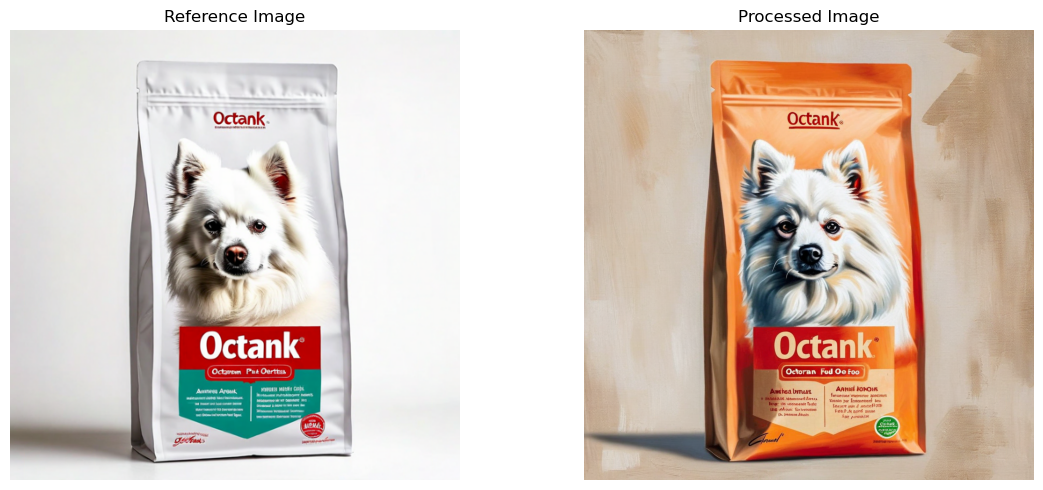

In [ ]:
# Encode the reference image into base64 format to send it as data
with open(reference_image_path, "rb") as image_file:  # Open the reference image file in read-binary mode
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")  # Encode the image as a base64 string

# Prepare the request to generate a new image based on the reference image
body = json.dumps(  # Convert the following dictionary into JSON format to send as a request
    {
        "taskType": "TEXT_IMAGE",  # Specify the task type: we're generating an image from text
        "textToImageParams": {
            "text": prompt,  # Provide the description (text) for generating the image (e.g., "Dog food packet with a dog")
            "conditionImage": reference_image_base64,  # Provide the base64-encoded reference image as a condition for the generation
            "controlMode": "CANNY_EDGE",  # Optional: Specify the control mode. "CANNY_EDGE" is for edge detection.
            "controlStrength": 0.7,  # Optional: Defines how strongly the control mode affects the output (range: 0.2 to 1.0)
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,  # Generate 1 image (you can change this number to generate more images)
            "seed": seed,  # Set the random seed for reproducibility (same prompt + seed will generate the same image)
        }
    }
)

# Send the request to the AWS Bedrock model to generate the image
response = boto3_bedrock.invoke_model(  # Call the AWS Bedrock API to generate the image
    body=body,  # The request body we prepared earlier
    modelId="amazon.nova-canvas-v1:0",  # Specify which Bedrock model to use for image generation
    accept="application/json",  # We expect the response in JSON format
    contentType="application/json"  # The request body is in JSON format
)

# Parse the response from AWS Bedrock
response_body = json.loads(response.get("body").read())  # Convert the response body from JSON to a Python dictionary

# Decode and open the image(s) returned by the model
response_images = [  # Loop through the images returned by the model (in case multiple images are generated)
    Image.open(io.BytesIO(base64.b64decode(base64_image)))  # Decode each base64 image and open it using PIL
    for base64_image in response_body.get("images")  # Get the images from the response
]

# Save the first generated image to the specified output file path
save_image(response_body.get("images")[0], output_save_path)  # Save the first image returned by the model

# Plot the generated image(s)
plot_images(response_images, ref_image_path = reference_image_path)  # Display the generated image along with the reference image


### **Explanation of the Code:**

- This code encodes the reference image, sends it along with a text prompt to AWS Bedrock for image generation, processes the response, saves the generated image, and then displays it for comparison.


1. **Encode the Reference Image**:
   - **`with open(reference_image_path, "rb") as image_file:`**:
     - Opens the **reference image** (located at **`reference_image_path`**) in **binary read mode** (`"rb"`).
   - **`reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")`**:
     - Reads the image file and **encodes** it into **Base64 format** using `base64.b64encode()`.
     - The `decode("utf-8")` converts the Base64 bytes to a **string** that can be included in the request payload.

2. **Generate Image Conditioned on Reference**:
   - **`body = json.dumps({...})`**:
     - This constructs the **JSON body** for the request to **AWS Bedrock** for **image generation**.
     - The body contains:
       - **`taskType: "TEXT_IMAGE"`**: Specifies that the task is **text-to-image generation**.
       - **`textToImageParams`**:
         - **`text`**: The description of the image to generate (the **prompt**).
         - **`conditionImage`**: The **Base64-encoded reference image** used to guide the image generation.
         - **`controlMode`**: The style of conditioning, either **`CANNY_EDGE`** or **`SEGMENTATION`**.
         - **`controlStrength`**: Controls the strength of the applied condition (range from 0.2 to 1.0).
       - **`imageGenerationConfig`**: Contains configuration settings for the image generation:
         - **`numberOfImages`**: Specifies that **1 image** should be generated.
         - **`seed`**: Used for **reproducibility**, ensuring the same result for the same input.

3. **Invoke the Model**:
   - **`response = boto3_bedrock.invoke_model(...)`**:
     - Sends the request to the **AWS Bedrock** model (`"amazon.nova-canvas-v1:0"`) to generate the image.
     - The `response` contains the generated image in **Base64 format**.

4. **Process the Response**:
   - **`response_body = json.loads(response.get("body").read())`**:
     - Converts the **JSON response** from the model into a Python dictionary.
   - **`response_images = [...]`**:
     - Decodes the **Base64 images** from the response and converts them into **PIL Image objects**.

5. **Save the Generated Image**:
   - **`save_image(response_body.get("images")[0], output_save_path)`**:
     - Saves the first generated image from the response to the specified **`output_save_path`** (e.g., `"images/after_image_cartooning.png"`).

6. **Plot the Generated Image**:
   - **`plot_images(response_images, ref_image_path = reference_image_path)`**:
     - Uses the `plot_images` function to display the generated image alongside the reference image.





### 2.3 Example: Inpainting

#### Scenario
Octank has decided to refresh their product line by featuring different dog breeds on their packaging. However, they want to maintain consistency in the overall design and only change the dog image. This is where inpainting comes in handy. For this task, Octank wants to replace the American Eskimo dog on their current packaging with a Husky, while keeping the rest of the design intact.

Let's use inpainting to help Octank update their packaging with a new dog breed.

#### Parameters

1. **prompt**: Describes the desired output
2. **reference_image_path**: Path to the reference style
3. **mask_prompt**: Describe the object to be replaced

In [ ]:
# Define the prompt and reference image
prompt = "A white packet of premium dog food with Husky dog on it, professional product photography. Dog food is named Octank"
# The **prompt** is the description we want to generate. In this case, we're asking for a dog food package with a Husky dog on it.

negative_prompts = "bad quality, low res"
# The **negative prompts** specify qualities that should be avoided in the generated image. Here, we don't want the image to be of "bad quality" or "low resolution."

reference_image_path = "images/after_image_cartooning.png"
# **reference_image_path** is the file location of the image we want to base the new image on. It could be a previous version or a similar image.

mask_prompt = "American Eskimo dog"
# **mask_prompt** specifies what part of the image we want to change. In this case, we're looking to replace an "American Eskimo dog" with a Husky dog.

seed = 2  # Can be any random number between 0 to 214783647
# The **seed** is a number that helps to reproduce the exact same result when the same prompt is used. If you use the same seed, you get the same output.


### **Explanation of the Code:**

- This code defines a **text prompt** to guide image generation, provides a **reference image** for modification, specifies a **mask prompt** to indicate which part of the image to modify, and uses a **seed** to ensure the result can be reproduced.


1. **Define the Prompt**:
   - **`prompt`**: This is the **text description** that guides the model to generate the desired image. In this case, it specifies that the image should feature a **Husky dog** on a **premium dog food packet**, with the product name being **Octank**.

2. **Negative Prompts**:
   - **`negative_prompts`**: These are attributes to **avoid** in the generated image. For example, this specifies to avoid images with **"bad quality"** or **"low resolution"**.

3. **Reference Image Path**:
   - **`reference_image_path`**: This is the **path** to the **reference image** that the model will use to guide the generation process. The reference image will serve as a base for the **inpainting** process (i.e., modifying the image).

4. **Mask Prompt**:
   - **`mask_prompt`**: This specifies which part of the reference image should be replaced. In this case, the model is instructed to replace the **"American Eskimo dog"** with a new dog (e.g., **Husky**) while keeping the rest of the image the same.

5. **Seed**:
   - **`seed`**: A random number used for **reproducibility**. The same seed with the same prompt will generate the same result every time, allowing for consistent outputs.




In [ ]:
# Open the reference image and encode it in base64 format
with open(reference_image_path, "rb") as image_file:  # Open the reference image in read-binary mode ('rb')
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")  # Encode the image in base64 format

# Prepare the request to generate a new image based on the reference image
body = json.dumps(  # Convert the following Python dictionary into JSON format to send as a request
    {
        "taskType": "INPAINTING",  # Specify the task type as "INPAINTING", which means we want to modify part of the image
        "inPaintingParams": {
            "text": prompt,  # Optional: The description of what we want to change in the image (e.g., replacing a dog breed)
            "negativeText": negative_prompts,  # Optional: What we don't want in the generated image (e.g., low quality)
            "image": reference_image_base64,  # The reference image encoded in base64 format, which will be the base for the new image
            "maskPrompt": mask_prompt,  # Required: The specific area of the image we want to change (e.g., replace "American Eskimo dog")
            # "maskImage": "base64-encoded string",  # Optional: If we wanted to use a specific mask image instead of a prompt, we could include it here
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,  # Generate 1 image (you can increase this number if you want more images)
            "seed": seed,  # Seed for randomness. Using the same seed will give the same result each time.
        }
    }
)

# Send the request to the AWS Bedrock model to generate the image
response = boto3_bedrock.invoke_model(  # This function sends the request to the AWS Bedrock API
    body=body,  # The body of the request we prepared earlier
    modelId="amazon.nova-canvas-v1:0",  # The model to use for generating the image (Amazon Nova Canvas in this case)
    accept="application/json",  # We want the response in JSON format
    contentType="application/json"  # The request body is in JSON format
)

# Parse the response from AWS Bedrock and decode the generated image(s)
response_body = json.loads(response.get("body").read())  # Read the response and convert it from JSON to a Python dictionary
response_images = [  # Loop through all images in the response (if multiple images are generated)
    Image.open(io.BytesIO(base64.b64decode(base64_image)))  # Decode each image from base64 and open it as an image
    for base64_image in response_body.get("images")  # Get the list of images from the response
]

# Plot the generated image(s) and compare it with the reference image
plot_images(response_images, ref_image_path=reference_image_path)  # Use the 'plot_images' function to display the images


### **Explanation of the Code:**

- This code reads a reference image, encodes it into Base64, sends it with a prompt for **inpainting** to **AWS Bedrock**, and then displays the modified image alongside the original reference image.

1. **Encode the Reference Image**:
   - **`with open(reference_image_path, "rb") as image_file:`**:
     - Opens the **reference image** in **binary read mode** (`"rb"`).
   - **`reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")`**:
     - Reads the image file and **encodes** it into **Base64** format. The `decode("utf-8")` converts the encoded image from bytes to a string, which is suitable for API requests.

2. **Generate Image Based on Reference Image**:
   - **`body = json.dumps({...})`**:
     - Creates a **JSON request** to send to the **AWS Bedrock** model (`"amazon.nova-canvas-v1:0"`) for **inpainting** (image modification).
     - The request includes:
       - **`taskType: "INPAINTING"`**: Specifies the task type is **inpainting**, where part of the image is modified based on the prompt.
       - **`inPaintingParams`**:
         - **`text`**: The description of what to change in the image (optional).
         - **`negativeText`**: Attributes to avoid in the generated image (optional).
         - **`image`**: The **Base64-encoded reference image** to use as a base.
         - **`maskPrompt`**: Specifies which part of the reference image to modify (in this case, the **dog breed**).
       - **`imageGenerationConfig`**:
         - **`numberOfImages`**: The number of images to generate (1 image in this case).
         - **`seed`**: A seed value for **reproducibility**. Using the same seed with the same prompt will generate the same image.

3. **Invoke the Bedrock Model**:
   - **`response = boto3_bedrock.invoke_model(...)`**:
     - Sends the **JSON request** to **AWS Bedrock** for processing. The response will contain the modified image(s).

4. **Process the Response**:
   - **`response_body = json.loads(response.get("body").read())`**:
     - Parses the JSON response from Bedrock, which contains the generated image(s) in **Base64 format**.
   - **`response_images = [...]`**:
     - Decodes the **Base64 image(s)** and converts them into **PIL Image objects** for further use (e.g., displaying or saving).

5. **Display the Image**:
   - **`plot_images(response_images, ref_image_path = reference_image_path)`**:
     - Uses the **`plot_images`** function to display the generated image alongside the original reference image for comparison.





### 2.4 Example: Color Conditioning

#### Scenario
Now, let's create a special promotional package design using Octank's brand color palette.

#### Parameters

1. **prompt**: Describes the desired output
2. **hex_color_code**: Provide reference hex color codes

In [ ]:
# Define the prompt, reference image, color code and path to store the generated images
prompt = "A white packet of premium dog food with an American Eskimo dog on it, professional product photography. Dog food is named Octank."
# The **prompt** is the description of the image we want to generate. Here, we are asking for a dog food package with an **American Eskimo dog** on it.

hex_color_code = ["#81FC81", "#C9D688", "#FFFFFF"]
# **hex_color_code** is a list of **hex color codes** that define specific colors we want to use in the image (e.g., brand colors for the packaging).
# Each color code corresponds to a color used in web design.

seed = 42  # Can be any random number between 0 to 214783647
# The **seed** is a random number used to ensure that the image generation is **reproducible**. If the same seed and prompt are used,
# the same image will be generated each time. It helps in generating consistent results.

output_save_path = "images/after_color_conditioning.png"
# **output_save_path** specifies where the generated image will be saved. In this case, it will be saved in the "images" folder with the name "after_color_conditioning.png".
# If the folder doesn't exist, we need to make sure it is created before saving the image.


### **Explanation of the Code:**

- This code defines the **text description** (`prompt`), the **hex color codes** (`hex_color_code`) for color conditioning, and a **seed** for reproducibility. It also sets the **output file path** to save the generated image.

1. **Define the Prompt**:
   - **`prompt`**: This is the **text description** that guides the image generation. In this case, it specifies a **white packet of premium dog food** with an **American Eskimo dog** on it, and the brand name **Octank**.

2. **Hex Color Code**:
   - **`hex_color_code`**: A list of **hex color codes** that will be used to condition the generated image with specific colors. The colors in this list are:
     - **`#81FC81`**: A light green color.
     - **`#C9D688`**: A light olive color.
     - **`#FFFFFF`**: White color.

3. **Seed**:
   - **`seed`**: A random integer used for **reproducibility**. The same seed with the same prompt will generate the same image, allowing for consistent results.

4. **Output Path**:
   - **`output_save_path`**: Specifies the **file path** where the generated image will be saved (e.g., `"images/after_color_conditioning.png"`).




In [ ]:
# Encode the reference image
with open(reference_image_path, "rb") as image_file:
    # Open the reference image file in "read-binary" mode ('rb') to access the raw image data
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    # Convert the raw image data into a base64-encoded string, so it can be easily transmitted over the web.

# Generate image condition on color palette
body = json.dumps({
    # Prepare the data to send to the AWS model in JSON format.
    "taskType": "COLOR_GUIDED_GENERATION",  # Specify the type of task. Here, we are generating an image based on a color palette.

    "colorGuidedGenerationParams": {
        "text": prompt,  # The description of the image we want to generate (e.g., dog food package with a Husky dog)
        "colors": hex_color_code,  # The color palette we want to guide the image generation (e.g., specific brand colors).
    },

    "imageGenerationConfig": {
        "numberOfImages": 1,  # The number of images we want to generate (in this case, we want only 1 image).
        "seed": seed,  # The seed is used to ensure the image is generated consistently with the same prompt and conditions.
    }
})

response = boto3_bedrock.invoke_model(
    # Send the prepared request to AWS Bedrock for image generation using the chosen model.
    body=body,  # The JSON body with all the parameters
    modelId="amazon.nova-canvas-v1:0",  # The model to use for generating the image (Nova Canvas in this case).
    accept="application/json",  # Specify that we expect the response in JSON format.
    contentType="application/json"  # Indicate that we are sending JSON content.
)

response_body = json.loads(response.get("body").read())
# Read the response from AWS Bedrock and convert it from JSON format to a Python dictionary.

response_images = [
    # Decode the base64 image(s) from the response and convert them into image objects.
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")  # For each image in the response, decode and open it.
]

# Save the first generated image to the specified path
save_image(response_body.get("images")[0], output_save_path)

# Plot the generated image and display the color palette used for generating it.
plot_images(response_images, color_codes = hex_color_code)  # Display the generated image along with the color palette used.


### **Explanation of the Code:**

- This code encodes the reference image, sends it along with the **text prompt** and **color palette** to **AWS Bedrock** for image generation, processes the response, saves the generated image, and displays it in the notebook.

1. **Encode the Reference Image**:
   - **`with open(reference_image_path, "rb") as image_file:`**:
     - Opens the **reference image** (located at **`reference_image_path`**) in **binary read mode** (`"rb"`).
   - **`reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")`**:
     - Reads the image and encodes it into **Base64 format**. The `decode("utf-8")` converts the Base64 bytes into a string that can be used in the API request.

2. **Generate Image Based on Color Palette**:
   - **`body = json.dumps({...})`**:
     - Constructs the **JSON request body** for the image generation task. This includes:
       - **`taskType: "COLOR_GUIDED_GENERATION"`**: Specifies that the task is **color-guided image generation**.
       - **`colorGuidedGenerationParams`**:
         - **`text`**: The **text description** of the image to generate (the **`prompt`**).
         - **`colors`**: The list of **hex color codes** (`hex_color_code`) to guide the image generation with specific colors.
       - **`imageGenerationConfig`**:
         - **`numberOfImages`**: Specifies the number of images to generate (1 image in this case).
         - **`seed`**: Ensures **reproducibility** of the generated image. Using the same seed and prompt will produce the same image.

3. **Invoke the Bedrock Model**:
   - **`response = boto3_bedrock.invoke_model(...)`**:
     - Sends the **JSON request** to the **AWS Bedrock** model (`"amazon.nova-canvas-v1:0"`) for image generation. It receives the generated image(s) in **Base64 format**.

4. **Process the Response**:
   - **`response_body = json.loads(response.get("body").read())`**:
     - Converts the **JSON response** into a Python dictionary that contains the generated image(s).
   - **`response_images = [...]`**:
     - Decodes the **Base64 image(s)** from the response and converts them into **PIL Image objects** for display and further processing.

5. **Save the Generated Image**:
   - **`save_image(response_body.get("images")[0], output_save_path)`**:
     - Saves the **first generated image** from the response to the specified **`output_save_path`** (e.g., `"images/after_color_conditioning.png"`).

6. **Display the Image**:
   - **`plot_images(response_images, color_codes = hex_color_code)`**:
     - Uses the **`plot_images`** function to display the generated image alongside the provided color palette for comparison.




### 2.5 Example: Outpainting

#### Scenario
Now, Octank wants to create a professional-looking ad with this new product with kitchen background. To do this kind of background replacement, we will use the outpainting feature offered by Nova Canvas models.

We will first expand the image size to provide more room, then generating the new image using outpainting feature.

#### Parameters

1. **prompt**: Describes the desired output
2. **reference_image_path**: Path to image that will be edit
3. **mask_prompt**: Describe the area on the image that will not be edited

In [ ]:
# Define the prompt and reference image
prompt = "Dog food packet on a kitchen countertop"
# This is the description of what we want to generate. In this case, it's asking for an image of a **dog food packet** placed on a **kitchen countertop**.

reference_image_path = "images/after_color_conditioning.png"
# This is the **path** to the image that we are going to modify. We are using an image that has already been color-conditioned in the previous steps.

mask_prompt = "Dog food packet"
# This tells the model what part of the image should be modified or replaced. In this case, we are focusing on modifying the "dog food packet" area in the image.

seed = 100  # Can be any random number between 0 to 214783647
# The **seed** is a random number used to ensure the image is generated consistently with the same conditions.
# If the same seed and prompt are used, the same image will be generated every time.

# Expansion setting
target_width = 2048
# **target_width** defines the width (in pixels) of the new image we want to create. We are expanding the image to 2048 pixels.

target_height = 2048
# **target_height** defines the height (in pixels) of the new image. We are expanding the image to 2048 pixels in height.

horizontal_position_percent = 0.3
# **horizontal_position_percent** determines where the original image will be placed in the new expanded canvas.
# A value of 0.3 means it will be positioned slightly to the left side (30% from the left).

vertical_position_percent = 0.5
# **vertical_position_percent** determines where the original image will be placed vertically.
# A value of 0.5 means the image will be placed at the center of the new expanded canvas.

output_save_path = "images/after_outpainting.png"
# **output_save_path** is the location where the new generated image will be saved after processing.

# Specify path to store the output
expand_image_path = "images/expanded_image.png"
# **expand_image_path** is where we will temporarily store the image after expanding its canvas before generating the final image.


### **Explanation of the Code:**

- This code defines the **prompt**, **reference image**, and other parameters for the **outpainting** process. The goal is to expand the original image (by adding more space) and then generate additional content in that expanded area, based on the **prompt** provided. The final result will be saved at the specified **`output_save_path`**.

1. **Define the Prompt**:
   - **`prompt`**: This is the **text description** that guides the image generation. In this case, the prompt describes a **dog food packet** placed on a **kitchen countertop**.

2. **Reference Image Path**:
   - **`reference_image_path`**: This is the **path** to the **reference image** that will be used for generating the new image. In this case, the reference image is `after_color_conditioning.png`, which contains the original dog food packet image.

3. **Mask Prompt**:
   - **`mask_prompt`**: Specifies the area or object in the image to be replaced or modified. In this case, the **dog food packet** is the object to be modified (outpainted).

4. **Seed**:
   - **`seed`**: A random number (in this case, `100`) used for **reproducibility**. The same seed ensures that the image generation process will produce the same result every time it's run with the same prompt.

5. **Expansion Settings**:
   - **`target_width`**: The **width** of the new image after **outpainting** (2048 pixels).
   - **`target_height`**: The **height** of the new image after **outpainting** (2048 pixels).
   - **`horizontal_position_percent`**: The **horizontal position** (in percentage) to place the original image on the expanded canvas (set to `0.3`).
   - **`vertical_position_percent`**: The **vertical position** (in percentage) to place the original image on the expanded canvas (set to `0.5`).

6. **Output Save Path**:
   - **`output_save_path`**: This is the **path** where the **final generated image** will be saved, after the outpainting operation (e.g., `after_outpainting.png`).

7. **Expand Image Path**:
   - **`expand_image_path`**: This is the **path** where the expanded image (with extra canvas) will be saved before performing outpainting.




In [ ]:
# Load reference image
original_image = Image.open(reference_image_path)
# Open the reference image (the image we want to modify) from the specified path

original_width, original_height = original_image.size
# Get the width and height of the original image. These values will help us position the image correctly in the expanded canvas.

# Calculate the position of the original image on the expanded canvas.
position = (
    int((target_width - original_width) * horizontal_position_percent),
    int((target_height - original_height) * vertical_position_percent),
)
# This calculates where the original image will be placed on the expanded canvas.
# It uses the target dimensions (target_width and target_height) and positions the image at the specified percentage
# of the canvas width (horizontal_position_percent) and height (vertical_position_percent).

# Create an input image which contains the original image with an expanded canvas.
input_image = Image.new("RGB", (target_width, target_height), (235, 235, 235))
# Create a new blank image with the target dimensions (target_width, target_height). The color of the background is set to RGB (235, 235, 235).
input_image.paste(original_image, position)
# Place the original image on the newly created canvas at the calculated position.
input_image.save(expand_image_path)
# Save the image to the specified path (expand_image_path).

# Encode the reference image
with open(expand_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
# Open the expanded image and encode it in base64 format. This format is used for transmitting image data in a string format.
# It makes it easy to send the image over the web.

# Generate image condition on reference image
body = json.dumps(
    {
        "taskType": "OUTPAINTING",  # The task type is OUTPAINTING, which means we want to extend the image beyond its borders.
        "outPaintingParams": {
            "text": prompt,  # The description of what we want in the extended image (the prompt).
            "image": reference_image_base64,  # The base64-encoded reference image that we are extending.
            "maskPrompt": mask_prompt,  # We specify the part of the image we want to focus on (the mask).
            "outPaintingMode": "PRECISE",  # Use the PRECISE mode for better quality in the image generation.
        },
        "imageGenerationConfig": {
                "numberOfImages": 1,  # We want to generate just one image.
                "seed": seed,  # The seed ensures that the same image is generated consistently when the prompt and parameters are the same.
            }
    }
)

# Send the request to AWS Bedrock for generating the outpainted image
response = boto3_bedrock.invoke_model(
    body=body,
    modelId="amazon.nova-canvas-v1:0",  # Use the Nova Canvas model to generate the image.
    accept="application/json",
    contentType="application/json"
)

# Process the response from AWS Bedrock
response_body = json.loads(response.get("body").read())
# Convert the response body from JSON format into a Python dictionary.

response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    # Decode the base64 image(s) returned in the response and convert them into an image format that can be displayed.
    for base64_image in response_body.get("images")  # Get the images from the response.
]

# Save the generated image to the specified path
save_image(response_body.get("images")[0], output_save_path)
# Save the first image from the response to the output path.

# Plot the output
plot_images(response_images, ref_image_path=reference_image_path)
# Display the generated image and show the reference image next to it for comparison.


### **Explanation of the Code:**

- This code expands the original image (by adding extra space) and generates additional content in the expanded area using **outpainting**. The final image is saved and displayed alongside the original reference image.


1. **Load the Reference Image**:
   - **`original_image = Image.open(reference_image_path)`**:
     - Opens the **reference image** from the **`reference_image_path`**.
   - **`original_width, original_height = original_image.size`**:
     - Retrieves the **width** and **height** of the original image.

2. **Calculate the Position on the Expanded Canvas**:
   - **`position = (...)`**:
     - Calculates the **position** where the original image will be placed on the expanded canvas:
       - **`horizontal_position_percent`**: Determines where the image will be placed horizontally (relative to the width of the canvas).
       - **`vertical_position_percent`**: Determines where the image will be placed vertically (relative to the height of the canvas).
       - The `int()` function ensures the position is an integer value.

3. **Create the Expanded Canvas**:
   - **`input_image = Image.new("RGB", (target_width, target_height), (235, 235, 235))`**:
     - Creates a **new image** with a **size** of `target_width` x `target_height` and a **gray background** (RGB value: `235, 235, 235`).
   - **`input_image.paste(original_image, position)`**:
     - Pastes the original image onto the newly created canvas at the calculated **position**.

4. **Save the Expanded Image**:
   - **`input_image.save(expand_image_path)`**:
     - Saves the **expanded image** to **`expand_image_path`** (e.g., `"images/expanded_image.png"`).

5. **Encode the Expanded Image**:
   - **`with open(expand_image_path, "rb") as image_file:`**:
     - Opens the **expanded image** in **binary read mode**.
   - **`reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")`**:
     - **Encodes** the image into **Base64 format**, which is needed to send the image as part of the request to AWS.

6. **Generate Image with Outpainting**:
   - **`body = json.dumps({...})`**:
     - Creates the **JSON body** for the **outpainting** request. The body includes:
       - **`taskType: "OUTPAINTING"`**: Specifies that this is an **outpainting** task.
       - **`outPaintingParams`**:
         - **`text`**: The **prompt** to guide the image generation.
         - **`image`**: The **Base64-encoded expanded image**.
         - **`maskPrompt`**: The object to be replaced (e.g., **dog food packet**).
         - **`outPaintingMode`**: Specifies the type of outpainting (**`PRECISE`** or **`DEFAULT`**).
       - **`imageGenerationConfig`**:
         - **`numberOfImages`**: Specifies the number of images to generate (1 in this case).
         - **`seed`**: Ensures **reproducibility** of the image generation.

7. **Invoke the Model**:
   - **`response = boto3_bedrock.invoke_model(...)`**:
     - Sends the **JSON request** to **AWS Bedrock** for image generation.
     - The model processes the request and returns the generated image(s).

8. **Process the Response**:
   - **`response_body = json.loads(response.get("body").read())`**:
     - Parses the **JSON response** from the model into a Python dictionary.
   - **`response_images = [...]`**:
     - Decodes the **Base64** image(s) and converts them into **PIL Image objects**.

9. **Save the Generated Image**:
   - **`save_image(response_body.get("images")[0], output_save_path)`**:
     - Saves the **generated image** (first image in the response) to **`output_save_path`** (e.g., `"images/after_outpainting.png"`).

10. **Display the Generated Image**:
    - **`plot_images(response_images, ref_image_path = reference_image_path)`**:
      - Uses the **`plot_images`** function to display the **generated image** alongside the **reference image** for comparison.



### 2.6 Example: Background Removal

#### Scenario
Octank has professional photos of their existing gourmet dog food. They want to use these images across various marketing materials with different background. In our last use case, we will use Background Removal feature from Amazon Nova Canvas to help Ocktank isolate its product image from their original backgrond.

To use this feature, you just need to provide the image the model needs to work with.

In [ ]:
# Define image needs to be processed and path to store the generated images
reference_image_path = "images/after_outpainting.png"

### **Explanation of the Code:**

**Reference Image Path**:
   - **`reference_image_path = "images/after_outpainting.png"`**:
     - This variable defines the **path to the reference image** that will be used for further processing.
     - The image located at `"images/after_outpainting.png"` will be the base for the next task or transformation.


- This code simply sets the **path** to the **reference image** that will be used for further operations (such as background removal or outpainting) in the image processing pipeline.


In [ ]:
# Read image from file and encode it as base64 string.
with open(reference_image_path, "rb") as image_file:
    input_image = base64.b64encode(image_file.read()).decode('utf8')
    # Open the image located at the specified path (reference_image_path) in binary mode ('rb').
    # The image is read and then encoded into base64 format, which converts the image into a text string.
    # This allows the image to be sent over the internet easily.

# Prepare the request body for the background removal task
body = json.dumps({
    "taskType": "BACKGROUND_REMOVAL",  # The type of task we are performing, in this case, background removal.
    "backgroundRemovalParams": {
        "image": input_image,  # The base64 encoded image that we want to process.
    }
})
# The body of the request is created in JSON format. It includes the task type (background removal) and the image we want to process.
# JSON is a format used for sending data to a server, similar to a package that contains our request.

# Send the request to the AWS Bedrock model for processing
response = boto3_bedrock.invoke_model(
    body=body,  # The body contains the task and image data.
    modelId="amazon.nova-canvas-v1:0",  # The ID of the model we are using (Nova Canvas) to process the image.
    accept="application/json",  # The format in which we want the response (JSON).
    contentType="application/json"  # The format of the request body (JSON).
)
# The request is sent to AWS Bedrock, which processes the image to remove the background, based on the provided model and task type.

# Parse the response received from the model
response_body = json.loads(response.get("body").read())  # Parse the response body (JSON) into a Python dictionary.
# This converts the response, which is in JSON format, into a dictionary that we can easily work with.

# Decode and open the processed images from the response
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))  # Decode each image from base64 and open it as a readable image.
    for base64_image in response_body.get("images")  # Loop through the images returned in the response.
]
# The processed image(s) are decoded from base64 format and opened for display.

# Plot output
plot_images(response_images, ref_image_path= reference_image_path, original_title='Original Image', processed_title='Processed Image without Background')
# The processed image(s) are displayed using the plot_images function, along with the original image for comparison.
# The titles of the images are set to indicate which is the original image and which is the processed one with the background removed.


### **Explanation of the Code:**

- This code reads the reference image, **encodes** it into **Base64 format**, sends it to **AWS Bedrock** for **background removal**, and then displays the **processed image** alongside the **original image**.


1. **Read and Encode Image**:
   - **`with open(reference_image_path, "rb") as image_file:`**:
     - Opens the image located at **`reference_image_path`** in **binary read mode** (`"rb"`).
   - **`input_image = base64.b64encode(image_file.read()).decode('utf8')`**:
     - Reads the image and **encodes** it into **Base64 format** using `base64.b64encode()`.
     - The `decode('utf8')` converts the Base64 byte data into a string that can be used in the API request.

2. **Prepare the Request Body**:
   - **`body = json.dumps({...})`**:
     - Creates the **JSON body** for the request to AWS Bedrock. The body includes:
       - **`taskType: "BACKGROUND_REMOVAL"`**: Specifies that the task is **background removal**.
       - **`backgroundRemovalParams`**:
         - **`image`**: The **Base64-encoded image** that needs background removal.

3. **Invoke the Bedrock Model**:
   - **`response = boto3_bedrock.invoke_model(...)`**:
     - Sends the **JSON request** to the **AWS Bedrock** model (`"amazon.nova-canvas-v1:0"`) to perform the background removal on the provided image.

4. **Process the Response**:
   - **`response_body = json.loads(response.get("body").read())`**:
     - Converts the **JSON response** into a Python dictionary.
   - **`response_images = [...]`**:
     - Decodes the **Base64**-encoded generated image(s) and converts them into **PIL Image objects**.

5. **Display the Generated Image**:
   - **`plot_images(response_images, ref_image_path= reference_image_path, original_title='Original Image', processed_title='Processed Image without Background')`**:
     - Uses the `plot_images` function to display the **generated image** alongside the **original reference image** for comparison.
     - The **title** for the original image is set to `'Original Image'`, and the title for the processed image is set to `'Processed Image without Background'`.





## 3. Responsible AI in Action

To continue supporting best practices in the responsible use of AI, Amazon Nova Canvas has built to detect and remove harmful content in the data, reject inappropriate content in the user input, and filter the models’ outputs that contain inappropriate content (such as hate speech, profanity, and violence).

Octank marketing team wants generate an appealing campaign by placing and image of Scooby Doo on the package.

In [ ]:
# Define the prompt with some inputs blocked for being copyright image.
prompt = "A white packet of premium dog food with Scooby Doo on it, professional product photography. Dog food is named Octank."
# **prompt**: This is the description that tells the AI what kind of image to create. In this case, it’s describing a product (dog food) with the image of Scooby Doo on the packet.
# We have intentionally avoided using specific copyrighted names to ensure that the AI doesn’t attempt to generate images that may violate copyrights.

negative_prompts = "poorly rendered, poor background details, poor packet details, poor text details, bleary text"
# **negative_prompts**: This defines what we do not want in the generated image. In this case, we are specifying that we don’t want poor-quality details, blurry text, or bad image rendering.

seed = 42  # Seed for randomization, ensuring reproducibility of the same image each time.
# **seed**: This is used to generate consistent results for the same prompt. The same seed value will result in the same image being generated every time, ensuring reproducibility.


### **Explanation of the Code:**

- This code defines a **text description** (`prompt`) for the image generation, sets the **negative prompts** to exclude unwanted qualities from the image, and uses a **seed** for reproducibility. The **negative prompts** help ensure the generated image is of high quality.


1. **Define the Prompt**:
   - **`prompt`**: This is the **text description** that guides the image generation. In this case, it specifies a **white packet of premium dog food** with **Scooby Doo** on the packaging, and the dog food brand is **Octank**. However, as the character **Scooby Doo** is copyrighted, this prompt may trigger a validation error or be blocked by the model for copyright reasons.

2. **Negative Prompts**:
   - **`negative_prompts`**: These are attributes that should **not** appear in the generated image. In this case, the model is instructed to avoid images with **poor rendering**, **poor background details**, **blurry text**, and other similar undesirable qualities.

3. **Seed**:
   - **`seed`**: A **random number** (in this case, `42`) used to ensure **reproducibility**. Using the same **seed** and **prompt** will produce the **same output** every time, which is useful for consistent results.



In [ ]:
# Generate text-to-image
body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",  # Task type we are requesting: generating an image from text.
        "textToImageParams": {
            "text": prompt,  # The description of the image we want to generate. This is required.
            "negativeText": negative_prompts  # The qualities we do not want in the image. This is optional.
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,   # How many images should be generated. In this case, just 1 image.
            "quality": "standard",  # The quality of the image. Options are "standard" or "premium".
            "height": 1024,  # The height of the image in pixels.
            "width": 1024,   # The width of the image in pixels.
            "cfgScale": 7.5,  # Controls the scale of creativity in the image. Higher values result in more diverse outputs.
            "seed": 42  # A number used to generate the same image every time if needed. This ensures reproducibility.
        }
    }
)

try:
    # Send the request to AWS Bedrock to generate the image
    response = boto3_bedrock.invoke_model(
        body=body,  # The request body that contains the task details
        modelId="amazon.nova-canvas-v1:0",  # The specific model to be used for generating the image
        accept="application/json",  # We expect the response to be in JSON format
        contentType="application/json"  # The body we are sending is in JSON format
    )

    # Parse the response from AWS Bedrock
    response_body = json.loads(response.get("body").read())  # Read and convert the response into a Python dictionary

    # Decode and open the image(s) from the response
    response_images = [
        Image.open(io.BytesIO(base64.b64decode(base64_image)))  # Decode the base64-encoded image and open it for display
        for base64_image in response_body.get("images")  # Loop through the returned images (may be more than one)
    ]

    # Display the generated image(s)
    plot_images(response_images, processed_title="Generated Product Package")  # Plot the image(s) with a custom title

# Handle errors in case something goes wrong
except boto3_bedrock.exceptions.ValidationException as error:
    print(f"An error occurred: {error}")  # Handle validation errors, such as bad input

# Handle any other unexpected exceptions
except Exception as e:
    print(f"An unexpected error occurred: {e}")  # Catch any other errors and print the message


**Note that:** Amazon Bedrock gives validation error as the input prompt is asking for images of Scooby Dog and hence violates copyright.

### **Explanation of the Code:**

- This code generates an image from a **text prompt** using the **AWS Bedrock model**, handles any errors that might occur, and displays the generated image. The **seed** ensures that the same image can be generated multiple times with the same conditions.

1. **Prepare the Request Body**:
   - **`body = json.dumps({...})`**:
     - Creates a **JSON object** for the request to the AWS Bedrock service.
     - The body includes:
       - **`taskType: "TEXT_IMAGE"`**: Specifies that the task is **text-to-image generation**.
       - **`textToImageParams`**:
         - **`text`**: The **prompt** that describes the image to generate.
         - **`negativeText`**: Optional prompts to exclude certain qualities from the generated image (e.g., **"poorly rendered"**).
       - **`imageGenerationConfig`**:
         - **`numberOfImages`**: Specifies the number of images to generate (1 in this case).
         - **`quality`**: Defines the image **quality** ("standard" or "premium").
         - **`height`** and **`width`**: The **dimensions** of the generated image (1024x1024 pixels).
         - **`cfgScale`**: A **scale factor** for classifier-free guidance (ranges from 1.0 to 10.0). This affects how strongly the model adheres to the prompt.
         - **`seed`**: A **random number** (42 in this case) used to ensure that the same image can be generated again with the same conditions.

2. **Invoke the Bedrock Model**:
   - **`response = boto3_bedrock.invoke_model(...)`**:
     - Sends the **request body** to **AWS Bedrock** using the **`boto3`** library.
     - **`modelId="amazon.nova-canvas-v1:0"`**: Specifies which model to use (in this case, the **Nova Canvas** model for image generation).
     - **`accept="application/json"`** and **`contentType="application/json"`**: Define the **request** and **response** formats as JSON.

3. **Process the Response**:
   - **`response_body = json.loads(response.get("body").read())`**:
     - Parses the **JSON response** from AWS Bedrock, which contains the generated image(s) in **Base64 format**.
   - **`response_images = [...]`**:
     - Decodes the **Base64**-encoded image(s) and converts them into **PIL Image objects** for further processing.

4. **Plot the Generated Image**:
   - **`plot_images(response_images, processed_title="Generated Product Package")`**:
     - Displays the **generated image(s)** using the **`plot_images`** function.
     - The title for the image is set to **"Generated Product Package"**.

5. **Handle Errors**:
   - **`except boto3_bedrock.exceptions.ValidationException as error:`**:
     - Catches any **validation errors** from AWS Bedrock, which may occur due to issues like invalid prompts or models rejecting the request.
   - **`except Exception as e:`**:
     - Catches any **unexpected errors** and prints a message describing the error.





## 4. Summary and Next Steps

In this notebook lab, we explored the powerful features of Amazon Nova Cnavas through the lens of Octank, a premium dog food company. We covered:

- Text to Image
- Image Conditioning
- Color Variation
- Inpainting
- Color Conditioning
- Outpainting
- Background Removal
- Responsible AI in action

These tools enable Octank to efficiently create diverse, high-quality visuals for their marketing campaigns, maintaining brand consistency while adapting to various styles.

You can now leverage this GenAI-powered image generation to enhance your own creative workflows!
